In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Sat Nov  9 02:21:47 2024


In [2]:
data = df_collector.cboe_spx_asians().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected asian options


,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,2779.00000,1389.00000,7,1.00000,7,0,geometric,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,1389.38591
1,2779.00000,1389.00000,7,1.00000,7,0,geometric,put,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,0.00000
2,2779.00000,1389.00000,7,1.00000,7,0,arithmetic,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,1389.52615
3,2779.00000,1389.00000,7,1.00000,7,0,arithmetic,put,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,0.00000
4,2779.00000,2083.75000,7,1.00000,7,0,geometric,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,694.94232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138595,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509
138596,5857.00000,8785.00000,84,1.00000,84,0,geometric,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000
138597,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407
138598,5857.00000,8785.00000,84,1.00000,84,0,arithmetic,call,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,0.00000


In [3]:
pd.Series(np.random.normal(scale=0.002,size=10000)).describe()

count   10000.00000
mean        0.00000
std         0.00202
min        -0.00884
25%        -0.00135
50%         0.00001
75%         0.00135
max         0.00830
dtype: float64

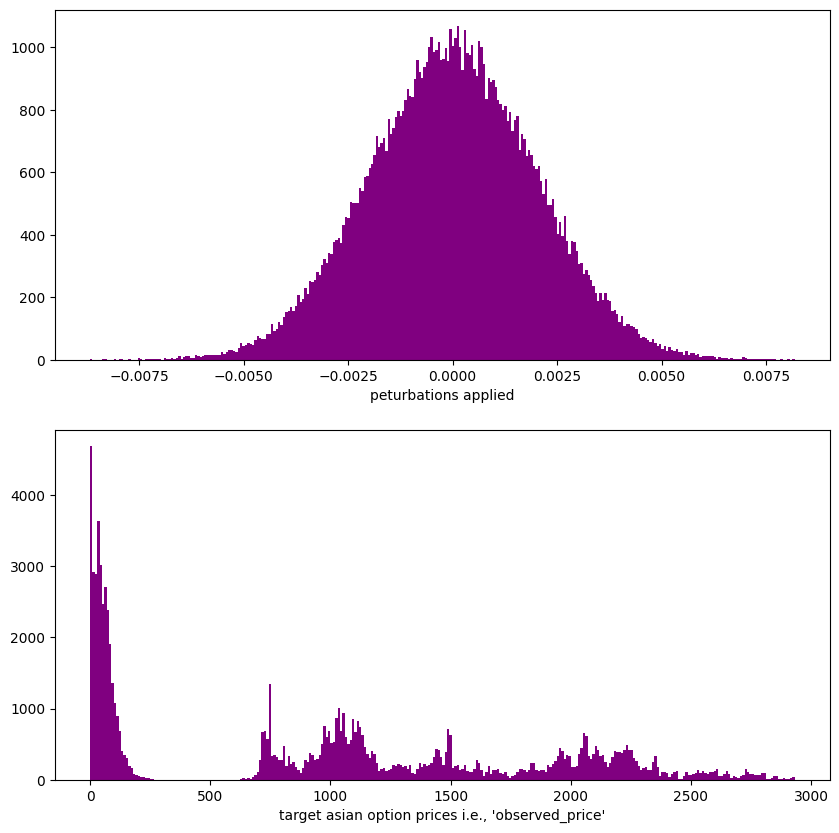

total data count: 87876
count   87876.00000
mean      974.59364
std       841.67844
min         0.28989
25%        68.32671
50%       991.40478
75%      1619.74453
max      2931.59786
Name: observed_price, dtype: float64


In [4]:
data = data[data[pricename]<=data['spot_price']]
data = data[data[pricename]>=0.01].copy()
data['observed_price'] = data[pricename]+np.random.normal(scale=0.002,size=data.shape[0])
data = data[data['observed_price']>=data['spot_price']*0.0001].copy()
p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

# training procedure

In [5]:
pricename

'asian_price'

In [6]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object


{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [7]:
trainer.raw_data

""


In [8]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,observed_price
0,2779.00000,1389.00000,7,1.00000,7,0,geometric,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,1389.38591,1389.38708
2,2779.00000,1389.00000,7,1.00000,7,0,arithmetic,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,1389.52615,1389.52368
4,2779.00000,2083.75000,7,1.00000,7,0,geometric,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,694.94232,694.94313
6,2779.00000,2083.75000,7,1.00000,7,0,arithmetic,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,695.08256,695.08337
8,2779.00000,2778.50000,7,1.00000,7,0,geometric,call,0.02300,0.02004,2019-05-29 16:14:27.624,0.02624,0.74762,-0.76994,0.55141,0.03230,2019-05-29,17.83894,17.83636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138591,5857.00000,5856.50000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,176.72445,176.72511
138593,5857.00000,7320.75000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1437.72795,1437.72710
138595,5857.00000,7320.75000,84,1.00000,84,0,arithmetic,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,1429.79509,1429.79477
138597,5857.00000,8785.00000,84,1.00000,84,0,geometric,put,0.04181,0.01269,2024-10-14 15:26:27.717,4.06705,0.00000,-0.71781,1.48700,0.12159,2024-10-14,2887.93407,2887.93540


## preprocessing

In [9]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2019-05-29
1      2019-06-03
2      2019-06-10
3      2019-06-12
4      2019-06-14
          ...    
570    2024-09-24
571    2024-10-07
572    2024-10-08
573    2024-10-09
574    2024-10-14
Length: 575, dtype: object

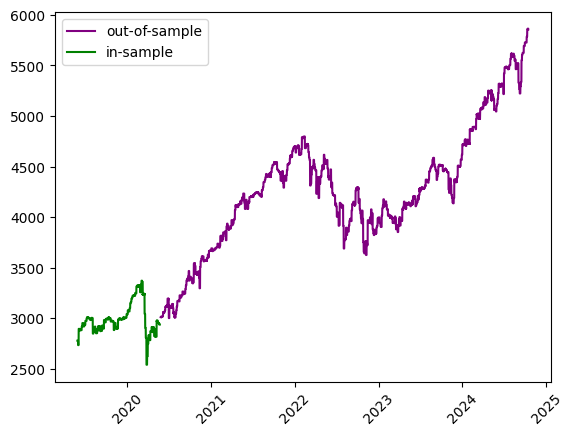

In [10]:
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [11]:
trainer.run_dnn()


training on 14766 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 1.8230040073394775


In [12]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'seed': 1312,
 'raw_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 0       2779.00000    1389.00000                 7    1.00000   
 2       2779.00000    1389.00000                 7    1.00000   
 4       2779.00000    2083.75000                 7    1.00000   
 6       2779.00000    2083.75000                 7    1.00000   
 8       2779.00000    2778.50000                 7    1.00000   
 ...            ...           ...               ...        ...   
 138591  5857.00000    5856.50000                84    1.00000   
 138593  5857.00000    7320.75000                84    1.00000   
 138595  5857.00000    7320.75000                84    1.00000   
 138597  5857.00000    8785.00000                84    1.00000   
 138599  5857.00000    8785.00000                84    1.00000   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                      7             0      geometric  call         0.02300   
 2                 

In [13]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   random_state=1312,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [14]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 10.797070324933253
     MAE: 6.410351895319044

out of sample:
     RMSE: 206.09180960391572
     MAE: 134.60429795235643


In [15]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

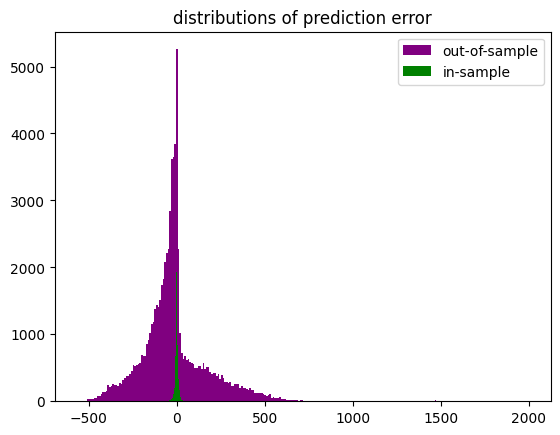

In [16]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [17]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_09 022151578699 cboe spx asian

cpu: 4.013417720794678


In [18]:
save_model()

model saved to E:\OneDrive - rsbrc\git_data\machine-learning-option-pricing\trained_models_dump\trained_models\2024_11_09 022151578699 cboe spx asian\2024_11_09 022151578699 cboe spx asian
